<a href="https://colab.research.google.com/github/yokahealthcare/Anasa-GAN/blob/master/%5BUdemy%5D%20%5BDCGAN%5D%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - MNIST
## Deep Convolutional Generative Adversial Network

## PART 1 : Data Preparation

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.11.0'

### Loading dataset MNIST

In [8]:
path = "dataset\mnist.npz"
with np.load(path) as data:
  X_train = data['x_train']
  Y_train = data['y_train']
  X_test = data['x_test']
  Y_test = data['y_test']

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [11]:
28 * 28

784

### Reshaping the training data (X)
> This must because CNN accept 4-Dimensional Numpy array as input
>
> **STRUCTURE** : (batch_size, height, width, channels)
>
> *Channels can RGB or GRAYSCALE*

In [12]:
X_train = np.reshape(X_train, (60000, 28, 28, 1)).astype("float")

### Scaling the data into range -1 to 1

In [13]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 255.0 	 min : 0.0


In [14]:
min_value = X_train[0].min()
max_value = X_train[0].max()
# using MinMaxScaler formula and modified it (range : -1 to 1)
X_train = 2 * ((X_train - min_value) / (max_value - min_value)) - 1

In [15]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 1.0 	 min : -1.0


### Change X_train to batch type variable

In [16]:
buffer_size = X_train.shape[0]   # length of data 60.000 row
batch_size = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

### Creating build_generator() functions

In [18]:
def build_generator():
  net = tf.keras.Sequential()
  net.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  net.add(layers.Reshape((7, 7, 256)))

  # 7 x 7 x 128
  net.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  # 14 x 14 x 64
  net.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

   # 28 x 28 x 1
  net.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))

  net.summary()
  return net

In [19]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [20]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1551683 ,  0.94351023,  0.23539849,  0.7496959 , -0.22569647,
         1.9522024 ,  0.4371608 , -0.5623063 ,  0.00940024, -0.18455957,
        -0.31602752, -0.5984106 , -0.067983  , -0.91577125, -0.41173387,
        -0.62312686, -0.988458  ,  0.53712416, -0.07424751,  0.8438718 ,
         1.2245054 ,  0.30763614, -1.34423   , -1.3430405 ,  2.146876  ,
         0.56098205, -0.01138401,  0.54234314,  1.216191  ,  0.5284426 ,
         0.7377062 , -0.7120964 , -1.2125777 ,  0.6225832 ,  0.9178841 ,
         2.2955012 ,  0.03528455, -0.6297673 , -0.04885906, -0.24800299,
         0.9686493 , -0.04109482, -1.2459509 ,  0.37166792, -0.9789435 ,
         2.3008854 ,  1.1304427 , -1.0766438 ,  2.145348  ,  1.0154055 ,
        -0.15769857,  0.6221579 , -1.1844363 ,  0.5610869 ,  0.9452597 ,
        -0.53269774,  0.61262846,  0.9291125 ,  0.7448429 , -0.08231516,
        -0.3511573 ,  0.05782053, -0.12156405, -1.3342437 , -0.01797786,
 

In [21]:
generated_image = generator(noise, training = False)

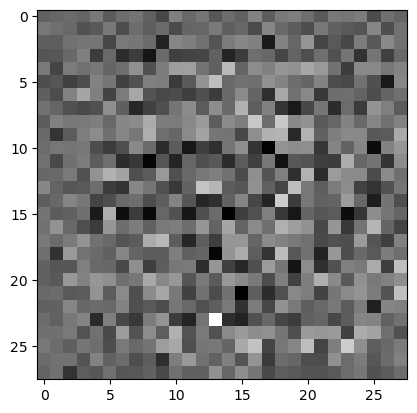

In [22]:
plt.imshow(generated_image[0], cmap="gray")